In [1]:
import numpy as np
from matplotlib import pyplot as pl
import ipywidgets
import sympy as sp

%matplotlib inline

In [2]:
sp.init_printing()

In [3]:
u_max = sp.symbols('u_max')
u_star = sp.symbols('u_star')
rho_max = sp.symbols('rho_max')
rho_star = sp.symbols('rho_star')
A, B = sp.symbols('A B')

In [4]:
type(u_max)

sympy.core.symbol.Symbol

In [5]:
u_max

In [7]:
u_max + u_star

In [8]:
# No traffic flux at max density
eq1 = sp.Eq(0, rho_max * u_max * (1 - A*rho_max - B*rho_max**2))
eq1

In [10]:
#Maximum flux when rho = rho_star
eq2 = sp.Eq(0, u_max * (1 - 2*A*rho_star - 3*B*rho_star**2))
eq2

In [12]:
#Velocity u_star when rho = rho_star
eq3 = sp.Eq(u_star, u_max * (1 - A*rho_star - B*rho_star**2))
eq3

In [16]:
#left hand side and right hand side
eq4 = sp.Eq(eq2.lhs - 3 * eq3.lhs, eq2.rhs - 3 * eq3.rhs)
eq4

In [17]:
eq4.simplify()

In [21]:
rho_star_sol = sp.solve(eq4, rho_star)[0]
rho_star_sol

In [22]:
type(rho_star_sol)

sympy.core.mul.Mul

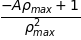

In [23]:
B_sol = sp.solve(eq1, B)[0]
B_sol

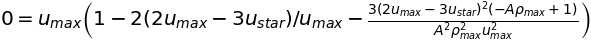

In [24]:
eq5 = eq2.subs([(rho_star, rho_star_sol),(B, B_sol)])
eq5

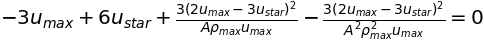

In [26]:
eq5.simplify()

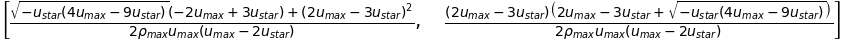

In [27]:
A_sol = sp.solve(eq5, A)
A_sol

In [28]:
A_val_0 = A_sol[0].evalf(subs={rho_max: 10.0, u_max: 1.0, u_star: 0.7})
A_val_0

In [30]:
A_val_1 = A_sol[1].evalf(subs={rho_max: 10.0, u_max: 1.0, u_star: 0.7})
A_val_1

In [33]:
A_val = max(A_val_0, A_val_1)
A_val

In [39]:
B_val = B_sol.evalf(subs={rho_max: 10.0, A: A_val})
B_val

In [40]:
def cubin_flux(rho, u_max, A, B):
    F = rho * u_max * (1 - A * rho - B * rho**2)
    return F

In [41]:
rho_max  =10.0
u_max = 1.0

L = 4.0
nx = 81
dx = L / (nx - 1)
x = np.linspace(0.0, L, num = nx)

In [43]:
rho0 = np.zeros_like(x)
mask = np.where(x<=2.0)
rho0[mask] = rho_max*x[mask]/2
rho0

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

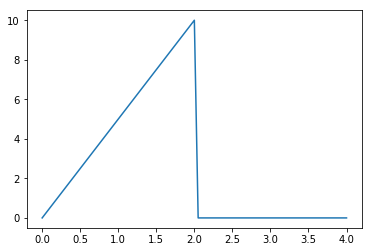

In [44]:
pl.plot(x, rho0);

In [75]:
def interactive_plot(x, rho_hist):
    nt = len(rho_hist)-1
    nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1, description='time step')
    w = ipywidgets.interactive(plot, n=nt_slider, x=ipywidgets.fixed(x), rho_hist=ipywidgets.fixed(rho_hist))
    return w

def plot(n, x, rho_hist):
    pl.figure()
    pl.grid()
    pl.title('Time step: {}'. format(n))
    pl.xlabel('Road [km]')
    pl.ylabel('Traffic density [car/h]')
    pl.plot(x, rho_hist[n])
    pl.xlim(x[0], x[-1])
    pl.ylim(0.0, 11.0)
    pl.show()

In [76]:
def FTBS(rho0, nt, dt, dx, u_max, rho_max, A, B):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        F = cubin_flux(rho, u_max, A, B)
        rho[1:] = rho[1:] - dt/dx * (F[1:] - F[:-1])
        rho_hist.append(rho.copy())
    return rho_hist
    

In [91]:
sigma = 1.0
dt = sigma * dx / u_max
nt = 30
A = A_val
B = B_val

rho_hist = FTBS(rho0, nt, dt, dx, u_max, rho_max, A, B)
interactive_plot(x, rho_hist)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


interactive(children=(IntSlider(value=0, description='time step', max=30), Output()), _dom_classes=('widget-in…

In [83]:
def lax_fniedrichs(rho0, nt, dt, dx, u_max, rho_max, A, B):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        F = cubin_flux(rho, u_max, A, B)
        rho[1:-1] = 1/2 * (rho[:-2] + rho[2:]) - dt /(2*dx) * (F[2:]-F[:-2])
        rho_hist.append(rho.copy())
        
    return rho_hist

In [87]:
sigma = 0.5
dt = sigma * dx / u_max
nt = 30
A = A_val
B = B_val

rho_hist = lax_fniedrichs(rho0, nt, dt, dx, u_max, rho_max, A, B)
interactive_plot(x, rho_hist)

interactive(children=(IntSlider(value=0, description='time step', max=30), Output()), _dom_classes=('widget-in…

In [88]:
def traffic_jacobian(rho, u_max, rho_max):
    J = u_max * (1 - 2*rho / rho_max)
    return J

def lax_wendroff(rho0, nt, dt, dx, u_max, rho_max, A,B):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        F = cubin_flux(rho, u_max, A, B)
        J = traffic_jacobian(rho, u_max, rho_max)
        rho[1:-1] = (rho[1:-1] - dt /(2*dx) * (F[2:]-F[:-2]) + dt**2 /
                     (4 * dx**2) * ((J[1:-1]+J[2:])*(F[2:]-F[1:-1]) - (J[1:-1]+J[:-2])*(F[1:-1]-F[:-2])))
        rho_hist.append(rho.copy())
    return rho_hist

In [92]:
sigma = 1.0
dt = sigma * dx / u_max
nt = 30
A = A_val
B = B_val

rho_hist = lax_wendroff(rho0, nt, dt, dx, u_max, rho_max, A, B)
interactive_plot(x, rho_hist)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in add
  if sys.path[0] == '':


interactive(children=(IntSlider(value=0, description='time step', max=30), Output()), _dom_classes=('widget-in…